In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from DCGAN import Discriminator, Generator, weights_init

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WORKER = 2

LEARING_RATE = 2e-4

BATCH_SIZE = 128

IMAGE_SIZE = 64

CHANNELS = 3 # RGB

Z_DIM = 100 # Noise dim

NUM_EPOCH = 10

FEATURES_DISC = 64

FEATURES_GEN = 64

GPU = 1

In [14]:
# Preprocessing images

# dataset
dataset = datasets.ImageFolder(root="data/Youngs/", 
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize(IMAGE_SIZE),
                                   torchvision.transforms.CenterCrop(IMAGE_SIZE),
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))                

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKER)

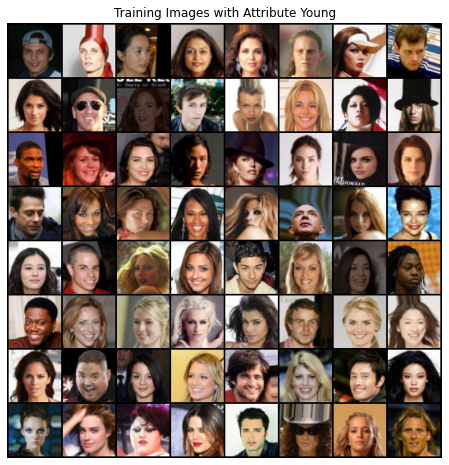

In [15]:
# Plot some samples
real_batch = next(iter(loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images with Attribute Young")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [16]:
# Generator and Discriminator initialization
netG = Generator(Z_DIM,FEATURES_GEN,CHANNELS,GPU).to(device)             # （噪声影像的通道数、特征图的通道数）
netD = Discriminator(CHANNELS, FEATURES_DISC,GPU).to(device)              # （图像的通道数、特征图的通道数）

# Initialize weights of Generator and Discriminator
netG.apply(weights_init)
netD.apply(weights_init)

# Optimizers of generator and discriminator
opt_G = optim.Adam(netG.parameters(), lr=LEARING_RATE, betas=(0.5, 0.999))
opt_D = optim.Adam(netD.parameters(), lr=LEARING_RATE, betas=(0.5, 0.999))

# Initialize BCELoss 
criterion  = nn.BCELoss()

# Set label of real images to 1, fake images to 0
real_lbl = 1.
fake_lbl = 0.

# Generate noise
fixed_noise = torch.randn(IMAGE_SIZE, Z_DIM, 1, 1, device=device)

In [17]:
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [18]:
# Lists to track training process
lossList_G = []
lossList_D = []
imgList = []

In [19]:
# Training
for epoch in range(NUM_EPOCH):
    
    # Load data
    for batch_idx, imgs in enumerate(loader,0):
        # 1) Data preparation
        real_img = imgs[0].to(device)
        img_size = real_img.size(0)
    ###############################################################
    
        # 2) Train discriminator network: max log(D(x)) + log(1-D(G(z)))

        netD.zero_grad()
            
        # Create all true batch
        # true_lbls = torch.ones(img_size, dtype=torch.float, device=device)
        true_lbls = torch.full((img_size,), real_lbl, dtype=torch.float, device=device)
        
        # Try to classify all real images to label 1
        output = netD(real_img).view(-1)
            
        # Calculate loss for classifying real images: 
        loss_real = criterion(output, true_lbls)
        loss_real.backward()
        D_true = output.mean().item()

            
        # Create all false batch
        false_lbls = true_lbls.fill_(fake_lbl)
            
        # Generate noise
        noise = torch.randn(img_size, Z_DIM, 1, 1,device=device)
        
        # Generate fake image from genenrator
        fake_img = netG(noise).detach()
        
        # Classify fake images
        fake_output = netD(fake_img).view(-1)
        
        # Calculate loss for classifying fake images:
        loss_fake = criterion(fake_output, false_lbls)
        loss_fake.backward()
        D_false = fake_output.mean().item()
            
        loss_D = loss_fake + loss_real
            
        opt_D.step()
            
    ###############################################################
    
        # 3) Train generator network: max log(D(G(z)))
        netG.zero_grad()
        
        # Create faked all true batch
        true_lbls = false_lbls.fill_(real_lbl)
            
        # Generate noise
        noise = torch.randn(img_size, Z_DIM, 1, 1,device=device)
            
        # Generate fake image from genenrator
        fake_img = netG(noise)
        
        # Classify fake images
        fake_output = netD(fake_img).view(-1)
        
        # Calculate loss for classifying fake images:
        loss_G = criterion(fake_output, true_lbls)
        loss_G.backward()
        G_D = fake_output.mean().item()
            
        opt_G.step()

    ###############################################################
        if batch_idx == (len(loader)-1):
            # Save images and model
            with torch.no_grad():
                fake_img = netG(fixed_noise).detach().cpu()
            
            imgList.append(vutils.make_grid(fake_img, padding=2, normalize=True))   
            vutils.save_image(fake_img.data,'result/CelebA/Youngs/img_gen/fake_img_%s.png' % epoch)
        
        # Print training stats        
        if batch_idx % 300 == 0 or batch_idx == (len(loader)-1):
            print(
                '[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, NUM_EPOCH, batch_idx, len(loader),
                   loss_D.item(), loss_G.item(), D_true, D_false, G_D)
            )
    
        lossList_G.append(loss_G.item())
        lossList_D.append(loss_D.item()) 


[0/10][0/1225]	Loss_D: 1.0987	Loss_G: 5.6148	D(x): 0.6928	D(G(z)): 0.4480 / 0.0078
[0/10][300/1225]	Loss_D: 0.8938	Loss_G: 6.9424	D(x): 0.9607	D(G(z)): 0.5045 / 0.0043
[0/10][600/1225]	Loss_D: 0.3426	Loss_G: 5.7358	D(x): 0.7766	D(G(z)): 0.0250 / 0.0080
[0/10][900/1225]	Loss_D: 0.5814	Loss_G: 5.5633	D(x): 0.9150	D(G(z)): 0.3293 / 0.0101
[0/10][1200/1225]	Loss_D: 0.7288	Loss_G: 6.5644	D(x): 0.9129	D(G(z)): 0.4050 / 0.0035
[0/10][1224/1225]	Loss_D: 0.4489	Loss_G: 4.1903	D(x): 0.8277	D(G(z)): 0.1339 / 0.0284
[1/10][0/1225]	Loss_D: 0.4201	Loss_G: 4.6162	D(x): 0.8472	D(G(z)): 0.1765 / 0.0208
[1/10][300/1225]	Loss_D: 1.7710	Loss_G: 6.5995	D(x): 0.9808	D(G(z)): 0.7618 / 0.0046
[1/10][600/1225]	Loss_D: 0.4575	Loss_G: 2.6208	D(x): 0.7520	D(G(z)): 0.0900 / 0.1134
[1/10][900/1225]	Loss_D: 0.4288	Loss_G: 3.3274	D(x): 0.8938	D(G(z)): 0.2340 / 0.0589
[1/10][1200/1225]	Loss_D: 0.6961	Loss_G: 3.5332	D(x): 0.8313	D(G(z)): 0.3520 / 0.0480
[1/10][1224/1225]	Loss_D: 0.5959	Loss_G: 5.4748	D(x): 0.9374	D(G(z

In [20]:
torch.save(netD.state_dict(),'Networks/Discriminator/net_disc_young.pth')
torch.save(netG.state_dict(),'Networks/Generator/net_gen_young.pth' )

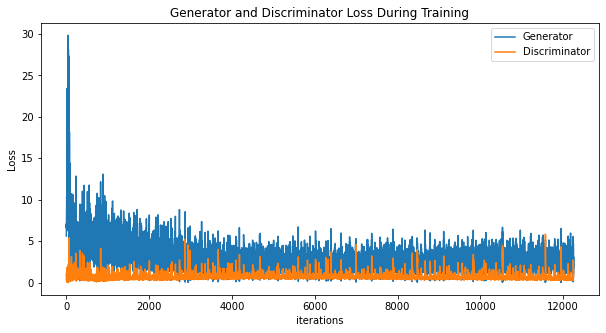

In [21]:
# Plot the loss of generator and discriminator
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(lossList_G,label="Generator")
plt.plot(lossList_D,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('result/CelebA/Youngs/Plots/Training_Loss.png')
plt.show()

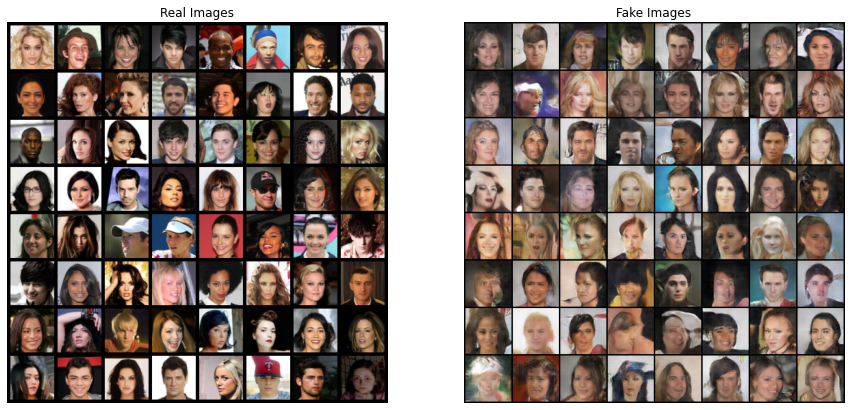

In [22]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(imgList[-1],(1,2,0)))
plt.savefig('result/CelebA/Youngs/Plots/Comparison.png')
plt.show()

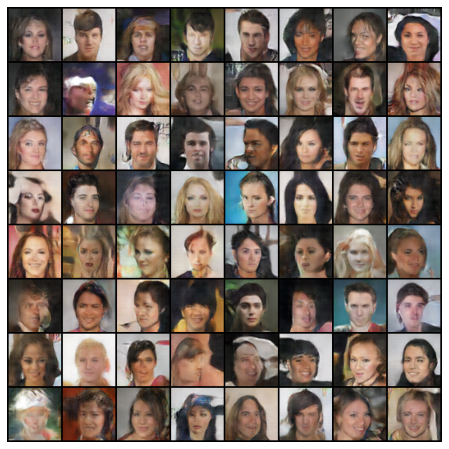

In [23]:
import matplotlib.animation as animation
from IPython.display import HTML

# Animation capture of how images produced by generator evolved
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in imgList]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())